## Compare 3D Convolutional Neural Networks

One approach when dealing with multiple frames is to employ 3D convolutional neural networks. In addition to convolving over the height and width of an image, we convolve through time (the depth dimension). We're hoping that this will allow us to detect changes in the video over time such as flickers or jitter.

In [1]:
import torch
import numpy as np
from fastai.core import *
from fastai.vision import *
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math
from functools import partial

__all__ = [
    'ResNet', 'resnet10', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
    'resnet152', 'resnet200'
]


def conv3x3x3(in_planes, out_planes, stride=1):
    # 3x3x3 convolution with padding
    return nn.Conv3d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False)


def downsample_basic_block(x, planes, stride):
    out = F.avg_pool3d(x, kernel_size=1, stride=stride)
    zero_pads = torch.Tensor(
        out.size(0), planes - out.size(1), out.size(2), out.size(3),
        out.size(4)).zero_()
    if isinstance(out.data, torch.cuda.FloatTensor):
        zero_pads = zero_pads.cuda()

    out = Variable(torch.cat([out.data, zero_pads], dim=1))

    return out


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 sample_size,
                 sample_duration,
                 shortcut_type='B',
                 num_classes=400):
        self.inplanes = 64
        super(ResNet, self).__init__()
        
        self.sample_duration = sample_duration
        self.conv1 = nn.Conv3d(
            3,
            64,
            kernel_size=7,
            stride=(1, 2, 2),
            padding=(3, 3, 3),
            bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], shortcut_type)
        self.layer2 = self._make_layer(
            block, 128, layers[1], shortcut_type, stride=2)
        self.layer3 = self._make_layer(
            block, 256, layers[2], shortcut_type, stride=2)
        self.layer4 = self._make_layer(
            block, 512, layers[3], shortcut_type, stride=2)
        
        last_duration = int(math.ceil(sample_duration / 16))
        last_size = int(math.ceil(sample_size / 32))
        self.avgpool = nn.AvgPool3d(
            (last_duration, last_size, last_size), stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                m.weight = nn.init.kaiming_normal_(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(
                    downsample_basic_block,
                    planes=planes * block.expansion,
                    stride=stride)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(
                        self.inplanes,
                        planes * block.expansion,
                        kernel_size=1,
                        stride=stride,
                        bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        batch_size, stacked_size, height, width = x.shape
        rgb_channels = 3

        # fastai requires that inputs be of shape:
        # (BATCH, CHANNELS * NUM_FRAMES, HEIGHT, WIDTH)
        # PyTorch's 3D convolution operations require that inputs be of shape:
        # (BATCH, CHANNELS, NUM_FRAMES, HEIGHT, WIDTH)
        x = x.view(batch_size,10, rgb_channels, height, width).permute(0, 2,1,3,4)

#         print(x.shape) #torch.Size([64, 3, 10, 128, 128])
#         plt.imshow(x[0,:,0,:,:].permute(1,2,0))
#         plt.show()
        
        # Reshaping and permuting puts x back on the CPU, so we'll move it back to the GPU.
        x = x.cuda()
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def get_fine_tuning_parameters(model, ft_begin_index):
    if ft_begin_index == 0:
        return model.parameters()

    ft_module_names = []
    for i in range(ft_begin_index, 5):
        ft_module_names.append('layer{}'.format(i))
    ft_module_names.append('fc')

    parameters = []
    for k, v in model.named_parameters():
        for ft_module in ft_module_names:
            if ft_module in k:
                parameters.append({'params': v})
                break
        else:
            parameters.append({'paramsbatch_size, height, width, stacked_size = input.shape': v, 'lr': 0.0})

    return parameters


def resnet10(**kwargs):
    """Constructs a ResNet-18 model.
    """
    model = ResNet(BasicBlock, [1, 1, 1, 1], **kwargs)
    return model


def resnet18(**kwargs):
    """Constructs a ResNet-18 model.
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model


def resnet34(**kwargs):
    """Constructs a ResNet-34 model.
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    return model


def resnet50(**kwargs):
    """Constructs a ResNet-50 model.
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model


def resnet101(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    return model


def resnet152(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model


def resnet200(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNet(Bottleneck, [3, 24, 36, 3], **kwargs)
    return model

In [3]:
path = Path('../data/hard_video_frames')

In [4]:
def open_video_frames_as_image(self, filename):
    # Open frames
    frames = np.load(filename)
        
    # Convert to tensor and normalize
    frames_tensor = torch.from_numpy(frames).float()
    frames_tensor.div_(255)
    
    frames_tensor = frames_tensor.permute(2, 0, 1)
    
    return Image(frames_tensor)
    
ImageList.open = open_video_frames_as_image

In [5]:
src = ImageList.from_folder(path, extensions='.npy').split_by_folder(train='train', valid='val')
src

ItemLists;

Train: ImageList (800 items)
Image (30, 149, 142),Image (30, 208, 206),Image (30, 265, 315),Image (30, 226, 224),Image (30, 231, 231)
Path: ../data/hard_video_frames;

Valid: ImageList (200 items)
Image (30, 238, 231),Image (30, 227, 249),Image (30, 223, 229),Image (30, 212, 220),Image (30, 107, 81)
Path: ../data/hard_video_frames;

Test: None

In [6]:
def get_data(bs,size):
    data = (src.label_from_re('([A-Z]+).npy$')
           .transform(get_transforms(max_warp=0, max_zoom=1), size=size)
           .databunch(bs=bs))
    #TODO: Normalize somehow
    return data

In [7]:
bs, sz = 32, 256
data = get_data(bs, sz)
# 10 frames in each sample
sample_duration = 10

In [8]:
def run_resnet(model_name):
    
    if model_name == "resnet18":
        model = resnet18(sample_size=sz, sample_duration=sample_duration, num_classes=400, shortcut_type='A')
        model = model.cuda()
        model = nn.DataParallel(model, device_ids=None)
        saved_state = torch.load('3DCNNs/resnet-18-kinetics.pth')
        state_dict = saved_state['state_dict']
        model.load_state_dict(state_dict)
        # Adjust the last layer to our problems classification task
        model.module.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)
        
    elif model_name == "resnet34":
        model = resnet34(sample_size=sz, sample_duration=sample_duration, num_classes=400, shortcut_type='A')
        model = model.cuda()
        model = nn.DataParallel(model, device_ids=None)
        saved_state = torch.load('3DCNNs/resnet-34-kinetics.pth')
        state_dict = saved_state['state_dict']
        model.load_state_dict(state_dict)
        # Adjust the last layer to our problems classification task
        model.module.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)
        
    elif model_name == "resnet50":
        bs, sz = 16, 256
        data = get_data(bs, sz)
        # 10 frames in each sample
        sample_duration = 10
        model = resnet50(sample_size=sz, sample_duration=sample_duration, num_classes=400, shortcut_type='B')
        model = model.cuda()
        model = nn.DataParallel(model, device_ids=None)
        saved_state = torch.load('3DCNNs/resnet-50-kinetics.pth')
        state_dict = saved_state['state_dict']
        model.load_state_dict(state_dict)
        # Adjust the last layer to our problems classification task
        model.module.fc = torch.nn.Linear(in_features=2048, out_features=2, bias=True)

    
    # Create a learner and group parameters 
    learner = Learner(data, model, metrics=[accuracy])
    
    learner.fit_one_cycle(20, 1e-4)
    
    # Post-Training Review
    learner.recorder.plot_losses()
    
    interp = ClassificationInterpretation.from_learner(learner)
    interp.plot_confusion_matrix()
    
    #interp.plot_top_losses(9, figsize=(10,10))

epoch,train_loss,valid_loss,accuracy,time
0,0.703897,0.720298,0.500000,00:35
1,0.619517,0.763985,0.500000,00:36
2,0.503174,0.711859,0.555000,00:36
3,0.421665,1.040994,0.615000,00:35
4,0.399619,0.891150,0.655000,00:35
5,0.370412,1.208535,0.555000,00:36
6,0.315531,1.038390,0.635000,00:35
7,0.293640,1.283667,0.600000,00:36
8,0.264763,0.814376,0.615000,00:37
9,0.200465,0.881492,0.635000,00:37


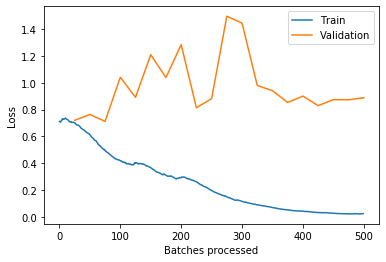

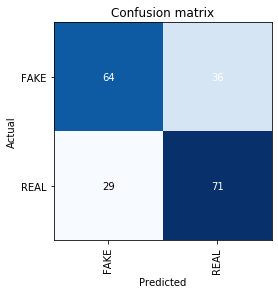

In [15]:
run_resnet('resnet18')

epoch,train_loss,valid_loss,accuracy,time
0,0.691068,0.709861,0.490000,00:52
1,0.572253,0.690080,0.555000,00:52
2,0.446609,1.601214,0.500000,00:51
3,0.432453,1.867411,0.530000,00:51
4,0.386260,1.056496,0.650000,00:50
5,0.350755,1.236677,0.535000,00:48
6,0.329058,0.861399,0.595000,00:49
7,0.298203,1.256348,0.565000,00:50
8,0.240927,0.823585,0.690000,00:50
9,0.207413,1.099386,0.590000,00:50


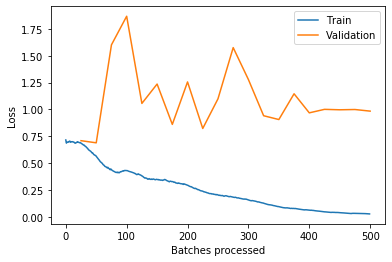

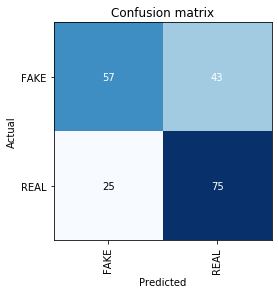

In [16]:
run_resnet('resnet34')

epoch,train_loss,valid_loss,accuracy,time
0,0.677473,0.722934,0.500000,00:46
1,0.544003,0.724788,0.610000,00:46
2,0.479616,0.811710,0.660000,00:46
3,0.454254,0.845747,0.635000,00:48
4,0.476506,0.794022,0.565000,00:47
5,0.453379,3.422552,0.495000,00:49
6,0.387415,0.574364,0.710000,00:48
7,0.325898,0.870639,0.660000,00:48
8,0.349059,0.663621,0.695000,00:48
9,0.281698,1.118446,0.670000,00:47


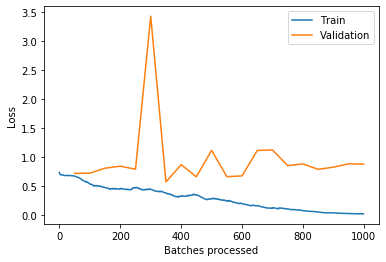

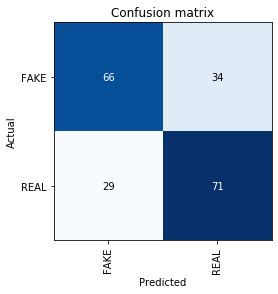

In [9]:
run_resnet('resnet50')

## Conclusions

|Network         | Pretrained     | Discriminitive | Final Accuracy % | Peak Accuracy %| Time for 1 Epoch (s) |
|----------------|----------------|----------------|------------------|----------------|----------------------|
|`resnet18-B`    |   True         |   False        |   67.5           |                |      36              |
|`resnet34-B`    |   True         |   False        |   66.0           |     69.0       |      50              |
|`resnet50-A`    |   True         |   False        |   **68.5**       |   **71.0**     |      47              |